# Analysis of mainnet transaction validation times

## Setup

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(quantreg, quietly=TRUE)
    require(VGAM, quietly=TRUE)
})

### Generate data

We use the `db-analyser` tool:

```bash
nix build 'github:IntersectMBO/ouroboros-consensus/release-ouroboros-consensus-diffusion-0.20.0.0#db-analyser'
```

Measure CPU usage starting from [Epoch 350](https://cardanoscan.io/block/7477993) and doing full application of blocks.

```bash
db-analyser \
  --db node.db/ \
  --analyse-from 65836843 \
  --benchmark-ledger-ops \
    --out-file ledger-ops-apply-65836843.csv \
  cardano --config node.json
```

Re-measure CPU usage but only reapplying blocks.

```bash
db-analyser \
  --db node.db/ \
  --analyse-from 65836843 \
  --benchmark-ledger-ops \
    --out-file ledger-ops-reapply-65836843.csv \
    --reapply \
  cardano --config node.json
```

The dominant difference between application and reapplication is the verification of transaction signatures and the execution of Plutus scripts.

<font color="red">WARNING: The measurements must be made on an otherwise idle machine because other CPU-heavy processes will interfere with the accuracy of `db-analyser`.</font>

## Read data

### Application

In [2]:
timingsApply <- fread("ledger-ops-apply-65836843.csv.gz")[
    `slot` >= 65836843, # Epoch 350
    .(
        `Slot`=`slot`,
        `Block [kB]`=`blockBytes`/1000,
        `Tx count`=as.numeric(`txs`),
        `Tx size [kB]`=txs_size/1000,
        `Tx exec [step]`=as.numeric(`txs_steps`),
        `Apply CPU [ms]`=`totalTime`/1000
    )
]
timingsApply %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836984   Min.   : 0.864   Min.   :  0.00   Min.   : 0.000  
 1st Qu.: 89833176   1st Qu.: 6.235   1st Qu.:  4.00   1st Qu.: 5.369  
 Median :113740091   Median :20.825   Median : 10.00   Median :19.962  
 Mean   :113666120   Mean   :31.091   Mean   : 14.19   Mean   :30.231  
 3rd Qu.:137528206   3rd Qu.:50.030   3rd Qu.: 21.00   3rd Qu.:49.175  
 Max.   :161151612   Max.   :90.061   Max.   :385.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]     
 Min.   :0.000e+00   Min.   :    0.255  
 1st Qu.:4.381e+08   1st Qu.:    2.087  
 Median :2.024e+09   Median :    5.593  
 Mean   :3.272e+09   Mean   :    8.202  
 3rd Qu.:5.067e+09   3rd Qu.:   11.468  
 Max.   :3.625e+10   Max.   :21960.779  

### Reapplication

In [3]:
timingsReapply <- fread("ledger-ops-reapply-65836843.csv.gz")[
    `slot` >= 65836843, # Epoch 350
    .(
        `Slot`=`slot`,
        `Reapply CPU [ms]`=`totalTime`/1000
    )
]
timingsReapply %>% summary

      Slot           Reapply CPU [ms]   
 Min.   : 65836984   Min.   :    0.046  
 1st Qu.: 89833176   1st Qu.:    0.357  
 Median :113740091   Median :    0.693  
 Mean   :113666120   Mean   :    1.205  
 3rd Qu.:137528206   3rd Qu.:    1.351  
 Max.   :161151612   Max.   :21445.038  

### Join the datasets

In [4]:
timings <- timingsApply[timingsReapply, on="Slot"]
timings[, `Apply - Reapply CPU [ms]`:=`Apply CPU [ms]`-`Reapply CPU [ms]`]
timings %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836984   Min.   : 0.864   Min.   :  0.00   Min.   : 0.000  
 1st Qu.: 89833176   1st Qu.: 6.235   1st Qu.:  4.00   1st Qu.: 5.369  
 Median :113740091   Median :20.825   Median : 10.00   Median :19.962  
 Mean   :113666120   Mean   :31.091   Mean   : 14.19   Mean   :30.231  
 3rd Qu.:137528206   3rd Qu.:50.030   3rd Qu.: 21.00   3rd Qu.:49.175  
 Max.   :161151612   Max.   :90.061   Max.   :385.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]      Reapply CPU [ms]   
 Min.   :0.000e+00   Min.   :    0.255   Min.   :    0.046  
 1st Qu.:4.381e+08   1st Qu.:    2.087   1st Qu.:    0.357  
 Median :2.024e+09   Median :    5.593   Median :    0.693  
 Mean   :3.272e+09   Mean   :    8.202   Mean   :    1.205  
 3rd Qu.:5.067e+09   3rd Qu.:   11.468   3rd Qu.:    1.351  
 Max.   :3.625e+10   Max.   :21960.779   Max.   :21445.038  
 Apply - Reapply CPU [ms]
 Min.   :-2073.664       
 1st Qu.:    1.65

### Sanity check

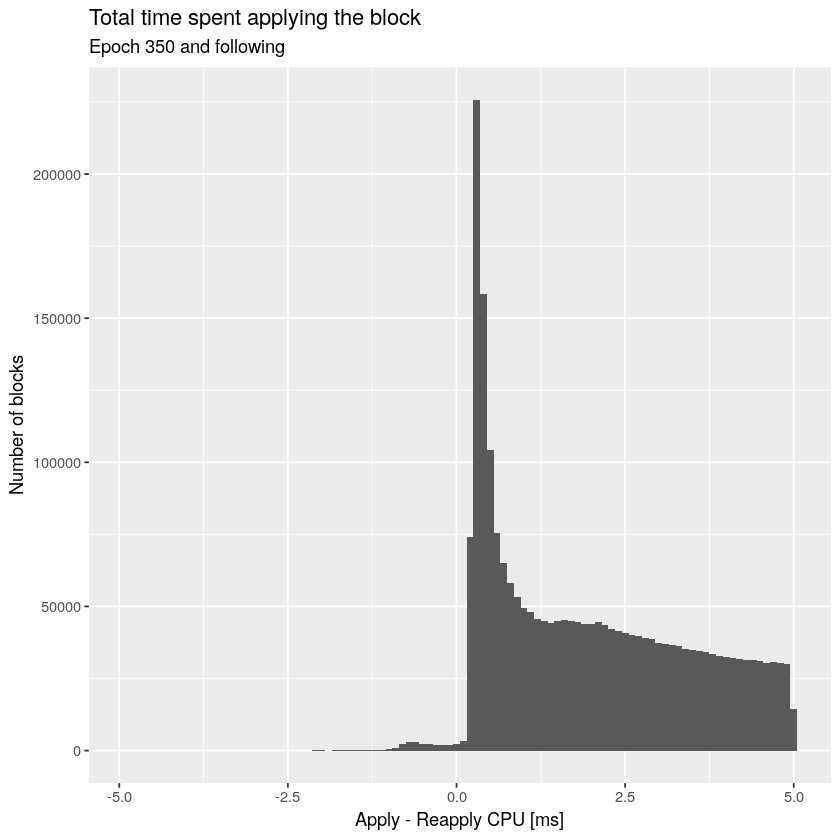

In [5]:
ggplot(timings[abs(`Apply - Reapply CPU [ms]`) < 5], aes(x=`Apply - Reapply CPU [ms]`)) +
    geom_histogram(binwidth=0.1) +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block",
        "Epoch 350 and following"
    )

From the above it appears that noisy measurements are not contaminating the results so much that we have many negative validation times.

### Cleanup

A few blocks have anomalously large times.

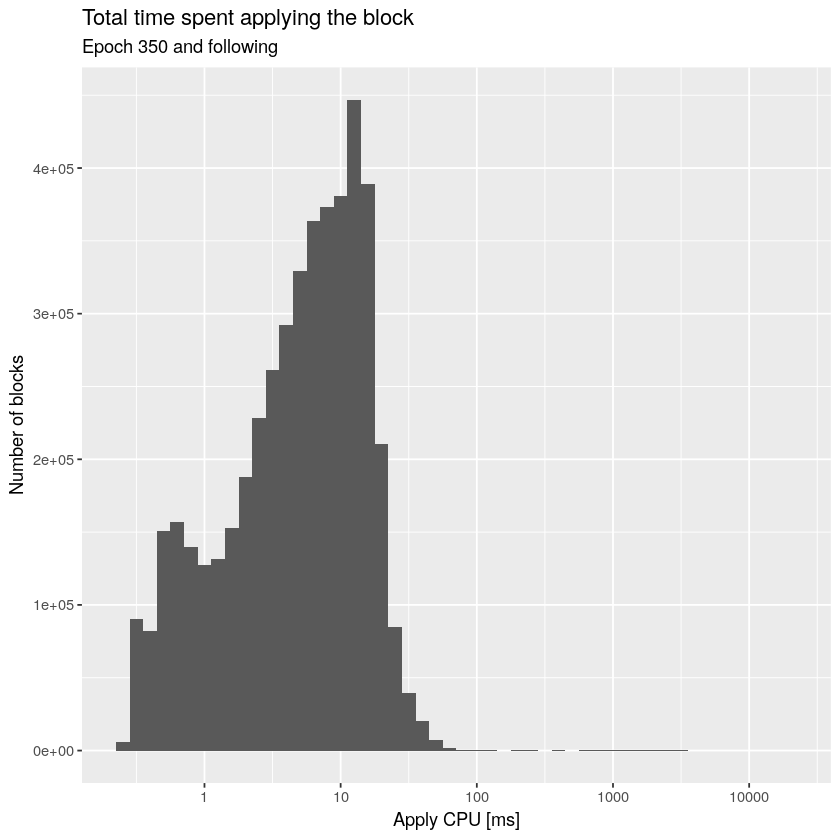

In [6]:
ggplot(timings, aes(x=`Apply CPU [ms]`)) +
    geom_histogram(binwidth=0.1) +
    scale_x_log10() +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block",
        "Epoch 350 and following"
    )

Ignore blocks that exceed the 95th %tile in CPU time because presumably there is something anomalous about these.

In [7]:
timeLimit <- timings[`Tx count` > 0, quantile(`Apply CPU [ms]`, 0.95)]
timeLimit

95% 
20.434

## Basic statistics

In [22]:
basics <- timings[
    `Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`,
    .(
        `Apply CPU [ms/tx]`=`Apply CPU [ms]`/`Tx count`,
        `Reapply CPU [ms/tx]`=`Reapply CPU [ms]`/`Tx count`,
        `Delta CPU [ms/tx]`=(`Apply CPU [ms]`-`Reapply CPU [ms]`)/`Tx count`,
        `Apply CPU [ms/kB]`=`Apply CPU [ms]`/`Tx size [kB]`,
        `Reapply CPU [ms/kB]`=`Reapply CPU [ms]`/`Tx size [kB]`,
        `Delta CPU [ms/kB]`=(`Apply - Reapply CPU [ms]`)/`Tx size [kB]`
    ),
    .(
        `Slot`
    )
]
basics %>% summary

      Slot           Apply CPU [ms/tx]  Reapply CPU [ms/tx] Delta CPU [ms/tx]
 Min.   : 65836998   Min.   : 0.08147   Min.   :0.02209     Min.   : 0.0000  
 1st Qu.: 88504476   1st Qu.: 0.37600   1st Qu.:0.05337     1st Qu.: 0.3039  
 Median :112127516   Median : 0.51383   Median :0.06753     Median : 0.4284  
 Mean   :112624206   Mean   : 0.61547   Mean   :0.09040     Mean   : 0.5251  
 3rd Qu.:136311264   3rd Qu.: 0.72960   3rd Qu.:0.09850     3rd Qu.: 0.6346  
 Max.   :161151612   Max.   :20.24300   Max.   :5.29300     Max.   :19.1210  
 Apply CPU [ms/kB] Reapply CPU [ms/kB] Delta CPU [ms/kB]
 Min.   :0.01286   Min.   :0.002513    Min.   :0.0000   
 1st Qu.:0.18437   1st Qu.:0.022842    1st Qu.:0.1564   
 Median :0.25257   Median :0.037642    Median :0.2115   
 Mean   :0.39816   Mean   :0.072896    Mean   :0.3253   
 3rd Qu.:0.45305   3rd Qu.:0.073733    3rd Qu.:0.3731   
 Max.   :8.79163   Max.   :3.451791    Max.   :8.5221   

### CPU time per transaction

In [23]:
melted <- melt(
    basics[, .(`Slot`, `Apply`=`Apply CPU [ms/tx]`, `Reapply`=`Reapply CPU [ms/tx]`, `Apply - Reapply`=`Delta CPU [ms/tx]`)],
    id.vars="Slot",
    measure.vars=c("Apply", "Reapply", "Apply - Reapply"),
    variable.name="Metric",
    value.name="CPU [ms/tx]"
)

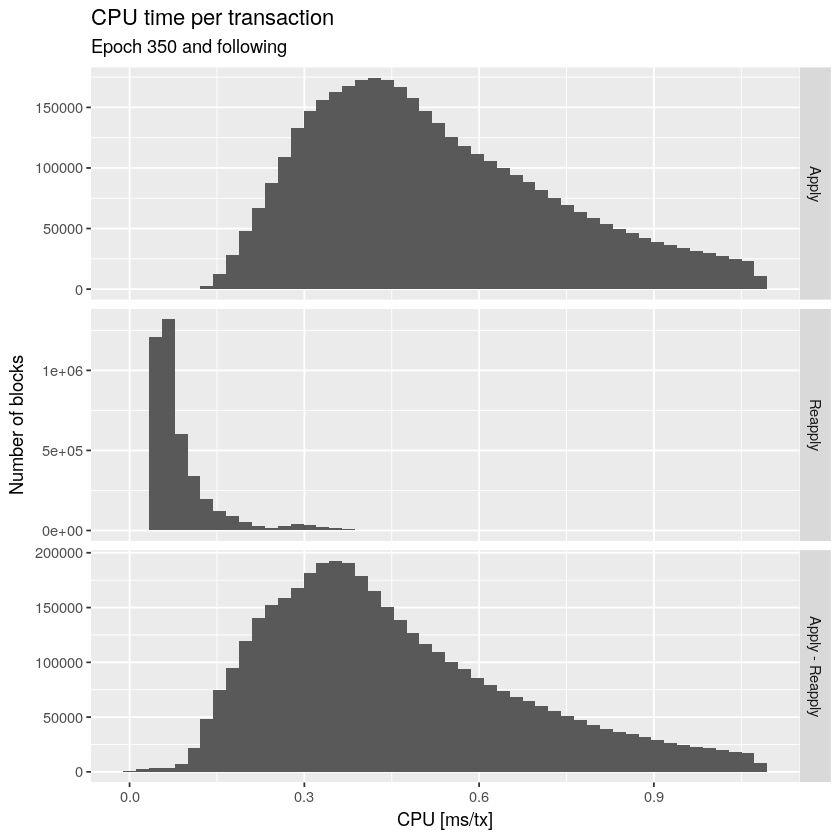

In [24]:
ggplot(melted[`CPU [ms/tx]` > 0 & `CPU [ms/tx]` < melted[, quantile(`CPU [ms/tx]`, 0.95)]], aes(x=`CPU [ms/tx]`)) +
    geom_histogram(bins=50) +
    ylab("Number of blocks") +
    facet_grid(`Metric` ~ ., scales="free_y") +
    ggtitle(
        "CPU time per transaction",
        "Epoch 350 and following"
    )

In [25]:
ggsave("cpu-per-tx.png", units="in", dpi=150, width=16, height=8)

In [26]:
melted[, .(`Median CPU [ms/tx]`=median(`CPU [ms/tx]`)), .(`Metric`)]

Metric,Median CPU [ms/tx]
<fct>,<dbl>
Apply,0.51383333
Reapply,0.06753333
Apply - Reapply,0.42842308


### CPU time per byte of transaction

In [27]:
melted <- melt(
    basics[, .(`Slot`, `Apply`=`Apply CPU [ms/kB]`, `Reapply`=`Reapply CPU [ms/kB]`, `Apply - Reapply`=`Delta CPU [ms/kB]`)],
    id.vars="Slot",
    measure.vars=c("Apply", "Reapply", "Apply - Reapply"),
    variable.name="Metric",
    value.name="CPU [ms/kB]"
)

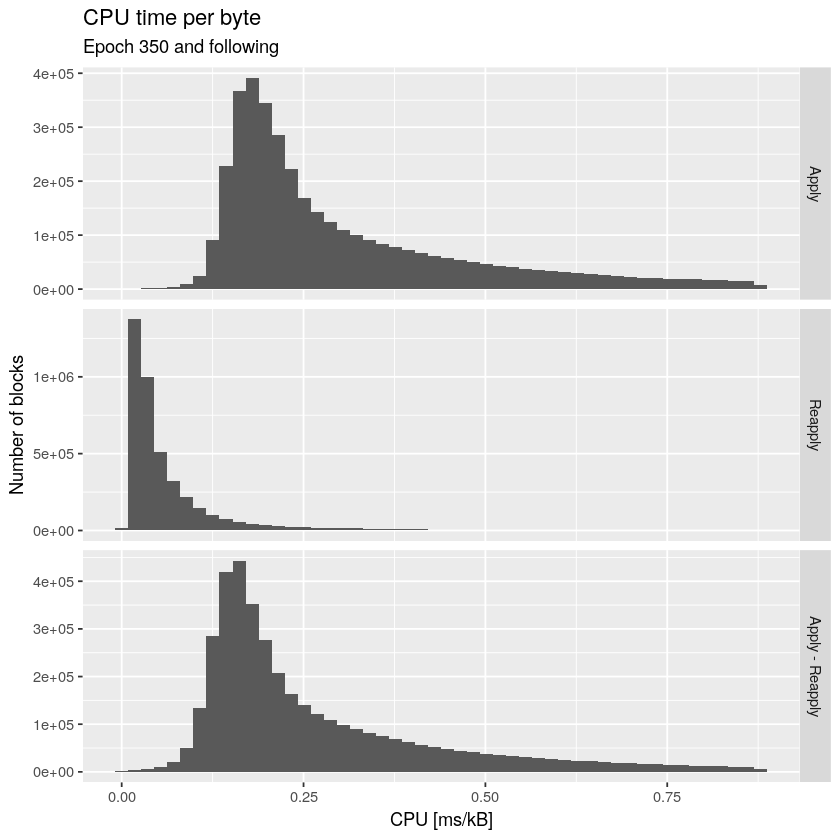

In [28]:
ggplot(melted[`CPU [ms/kB]` > 0 & `CPU [ms/kB]` < melted[, quantile(`CPU [ms/kB]`, 0.95)]], aes(x=`CPU [ms/kB]`)) +
    geom_histogram(bins=50) +
    ylab("Number of blocks") + 
    facet_grid(`Metric` ~ ., scales="free_y") +
    ggtitle(
        "CPU time per byte",
        "Epoch 350 and following"
    )

In [29]:
ggsave("cpu-per-kb.png", units="in", dpi=150, width=16, height=8)

In [30]:
melted[, .(`Median CPU [ms/kB]`=median(`CPU [ms/kB]`)), .(`Metric`)]

Metric,Median CPU [ms/kB]
<fct>,<dbl>
Apply,0.2525710
Reapply,0.0376423
Apply - Reapply,0.2115483


## Linear models for validation

### Independent variables: transaction count and size

In [31]:
model <- lm(
    `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]`, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`]
)
model %>% summary


Call:
lm(formula = `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]`, 
    data = timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & 
        `Reapply CPU [ms]` <= `Apply CPU [ms]`])

Residuals:
     Min       1Q   Median       3Q      Max 
-27.5274  -0.5576   0.2152   1.6654  18.0597 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
`Tx count`     1.481e-01  1.710e-04     866   <2e-16 ***
`Tx size [kB]` 1.141e-01  7.631e-05    1495   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.621 on 4148922 degrees of freedom
Multiple R-squared:  0.8833,	Adjusted R-squared:  0.8833 
F-statistic: 1.57e+07 on 2 and 4148922 DF,  p-value: < 2.2e-16


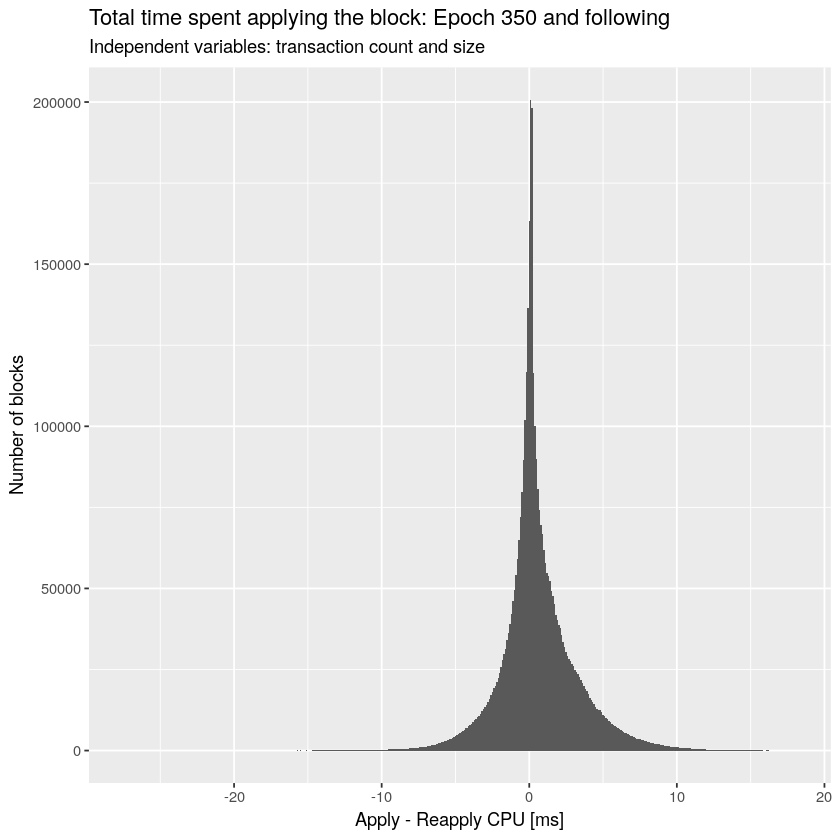

In [32]:
ggplot(data.table(`Actual - Fit [ms]`=residuals(model)), aes(`Actual - Fit [ms]`)) +
    geom_histogram(binwidth=0.1) +
    xlab("Apply - Reapply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count and size"
    )

The resulting model for validating a block (signature checking and running Plutus scripts) is:

```
(validation time) ~ 148.1 μs/tx * (Number of transactions) + 114.1 μs/kB * (size of transactions)
```

### Independent variables: transaction count, size, and execution steps

In [33]:
model <- lm(
    `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]` + `Tx exec [step]`, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`]
)
model %>% summary


Call:
lm(formula = `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]` + 
    `Tx exec [step]`, data = timings[`Tx count` > 0 & `Apply CPU [ms]` <= 
    timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`])

Residuals:
     Min       1Q   Median       3Q      Max 
-22.2733  -0.3085   0.2783   1.4133  17.6804 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
`Tx count`       1.375e-01  1.547e-04   888.5   <2e-16 ***
`Tx size [kB]`   6.020e-02  8.834e-05   681.4   <2e-16 ***
`Tx exec [step]` 5.852e-10  6.013e-13   973.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.365 on 4148921 degrees of freedom
Multiple R-squared:  0.905,	Adjusted R-squared:  0.905 
F-statistic: 1.317e+07 on 3 and 4148921 DF,  p-value: < 2.2e-16


In [34]:
timingsFit <- cbind(
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`],
    data.table(`Residual [ms]`=residuals(model))
)
timingsFit %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836998   Min.   : 1.022   Min.   :  1.00   Min.   : 0.159  
 1st Qu.: 88504476   1st Qu.: 7.733   1st Qu.:  5.00   1st Qu.: 6.868  
 Median :112127516   Median :21.417   Median : 10.00   Median :20.555  
 Mean   :112624206   Mean   :30.892   Mean   : 13.76   Mean   :30.030  
 3rd Qu.:136311264   3rd Qu.:47.396   3rd Qu.: 20.00   3rd Qu.:46.540  
 Max.   :161151612   Max.   :90.061   Max.   :201.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]   Reapply CPU [ms] Apply - Reapply CPU [ms]
 Min.   :0.000e+00   Min.   : 0.356   Min.   : 0.073   Min.   : 0.000          
 1st Qu.:5.896e+08   1st Qu.: 2.486   1st Qu.: 0.390   1st Qu.: 2.018          
 Median :2.091e+09   Median : 5.723   Median : 0.698   Median : 4.913          
 Mean   :3.137e+09   Mean   : 6.999   Mean   : 0.942   Mean   : 6.057          
 3rd Qu.:4.781e+09   3rd Qu.:10.876   3rd Qu.: 1.274   3rd Qu.: 9.478          
 Max.   :3.418e+

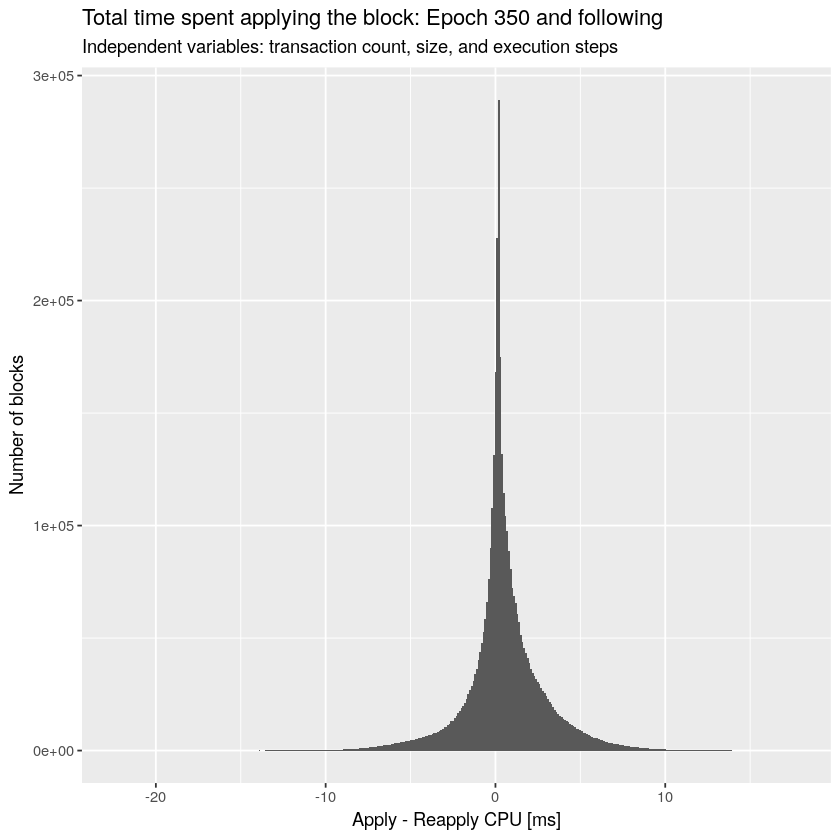

In [35]:
ggplot(timingsFit, aes(x=`Residual [ms]`)) +
    geom_histogram(binwidth=0.1) +
    xlab("Apply - Reapply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

In [36]:
ggsave("residual-histogram.png", units="in", dpi=150, width=16, height=8)

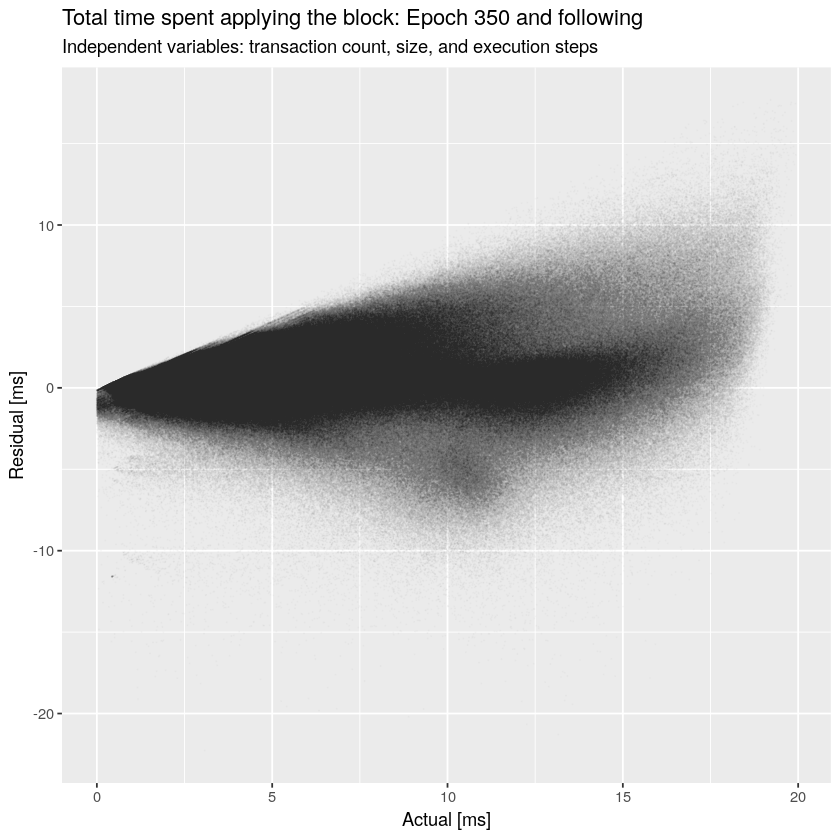

In [37]:
ggplot(
    timingsFit[, .(`Actual [ms]`=`Apply - Reapply CPU [ms]`, `Residual [ms]`)],
    aes(x=`Actual [ms]`, y=`Residual [ms]`)
) +
    geom_point(size=0.025, alpha=0.01) +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

In [38]:
ggsave("residual-scatterplot.png", units="in", dpi=150, width=16, height=8)

The previous plot indicates that nonlinear terms are present, and that a more sophisticate model might be possible, though we do not pursue this.

It turns out that the distribution of residuals are fit pretty well by a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) with location 0 and scale 1.25. We ignore heteroscedasticity.

In [39]:
b <- 1.25

In [40]:
errorModel <- data.table(`Residual [ms]`=-300:300/10, `Fit`=nrow(timingsFit)*dlaplace(-300:300/10, 0, b))

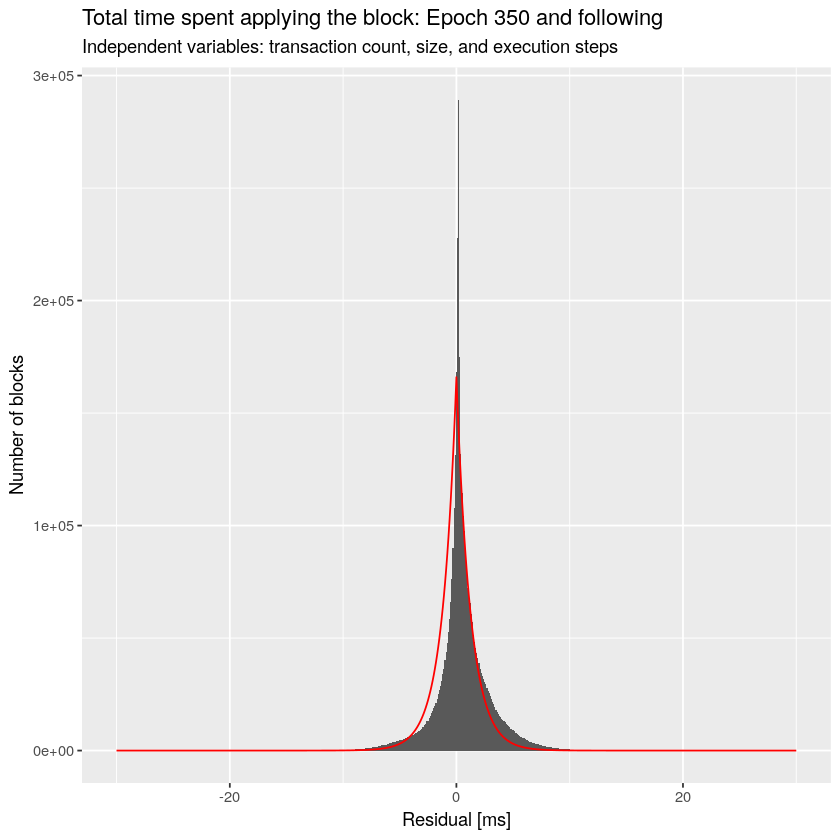

In [41]:
ggplot(timingsFit, aes(x=`Residual [ms]`)) +
    geom_histogram(binwidth=0.1) +
    geom_line(data=errorModel, aes(x=`Residual [ms]`, y=0.1*`Fit`), color="red") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

In [42]:
ggsave("residual-histogram-fit.png", units="in", dpi=150, width=16, height=8)

The resulting model for validating a block (signature checking and running Plutus scripts) is:

```
(validation time) ~ 137.5 μs/tx * (Number of transactions)
                  +  60.2 μs/kB * (size of transactions) 
                  + 585.2 μs/Gstep * (Plutus execution steps)
                  + (Laplace-distributed random variable with location 0 ms and scale 1.25 ms)
```

## Outliers

In [43]:
recentMax <- timings[`Slot` >= 160000000 & `Apply CPU [ms]` >= timings[`Slot` >= 160000000, max(`Apply CPU [ms]`)]]
recentMax

Slot,Block [kB],Tx count,Tx size [kB],Tx exec [step],Apply CPU [ms],Reapply CPU [ms],Apply - Reapply CPU [ms]
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
160444814,34.951,17,34.109,1810937370,2020.39,3432.924,-1412.534


This is [block 12100125](https://cexplorer.io/block/347993f8c93aa95a088c77732d054458597275e085bfdc9f00814e73e6f37000). Opening it in an explorer reveals that it contains several transactions with large number of NFTs and several Plutus scripts. Indeed, it did [propagate slowly](https://pooltool.io/realtime/12100125). Apparently, this is caused by [Cardano Ledger issue #3034](https://github.com/IntersectMBO/cardano-ledger/issues/3034).

Are these measures repeatable?

```bash
(
    for i in {1..10}
    do
        db-analyser --db node.db --analyse-from 160444759 --benchmark-ledger-ops --num-blocks-to-process 3 cardano --config node.json 2>/dev/null
    done
) | sed -n -e '1p;/160444814/p' | cut -f 1,3,4,5
```

```console
slot          totalTime     mut     gc
160444814       1891312 1451039 440273
160444814       1856810 1423818 432992
160444814       1860984 1424315 436668
160444814       1865990 1434216 431773
160444814       1864201 1427403 436798
160444814       1864993 1426206 438786
160444814       1875604 1430147 445457
160444814       1891785 1445674 446110
160444814       1878727 1435415 443311
160444814       1850210 1417927 432283
```

These results also provide a sense of how noisy the measurements are.

## Findings

We completed the basic analysis of block and transaction validation times for Cardano `mainnet` since Epoch 350. Results differ significantly from the preliminary results because it was discovered that `db-analyser` output is not reliable when it is run on a machine that has other CPU load: the new analysis is based on a clean dataset that was run on an otherwise idle machine.

1. The `db-analyser` tool can be used to measure the Cardno block-application time, either including or not including verifying transaction signatures and running Plutus scripts.
2. Ideally, `db-analyser` could be modified to report CPU times for phase 1 and phase 2 validation on a per-transaction basis.
3. The output of this tool is quite noisy and does not include enough of the explanatory variable for predicting CPU times for transactions or blocks.
4. The missing explanatory variables (size of UTxO set, number of inputs, number of outputs, etc.) can be extracted from the ledger or `cardano-db-sync`.
5. For transaction signature verification and Plutus script execution, the median times for blocks are . . .
    - 428.4 μs/tx
    - 211.5 μs/kB
    - Jointly via a linear model, 148.1 μs/tx plus 114.1 μs/kB.
    - Jointly via a linear model, 137.5 μs/tx plus 60.2 μs/kB plus 585.2 μs/Gstep, with a Lapace-distributed error having location 0 μs and scale 1250 μs.
6. The results above are not very good fits and are quite sensitive to the cutoff for discarding outliers.
7. The noise in the data and the uncertainty in predictions make the above values unsuitable for estimating individual transactions but suitable for bulk estimates of many blocks.
8. A more sophisticated double general linear model could be used to generate artificial transaction workloads.
9. The CPU-timing parameters in the default configuration for Leios simulations could be reduced based on this work.

## Addendum 1

### Linear models for application

In [44]:
timeLimit <- timings[`Tx count` > 0, quantile(`Apply CPU [ms]`, 0.99)]
timeLimit

99% 
32.662

#### Independent variables: transactions count

In [45]:
model <- lm(
    `Apply CPU [ms]` / `Tx count` ~ 1, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit]
)
model %>% summary


Call:
lm(formula = `Apply CPU [ms]`/`Tx count` ~ 1, data = timings[`Tx count` > 
    0 & `Apply CPU [ms]` <= timeLimit])

Residuals:
   Min     1Q Median     3Q    Max 
-0.539 -0.240 -0.101  0.114 31.807 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.620105   0.000201    3084   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4189 on 4342018 degrees of freedom


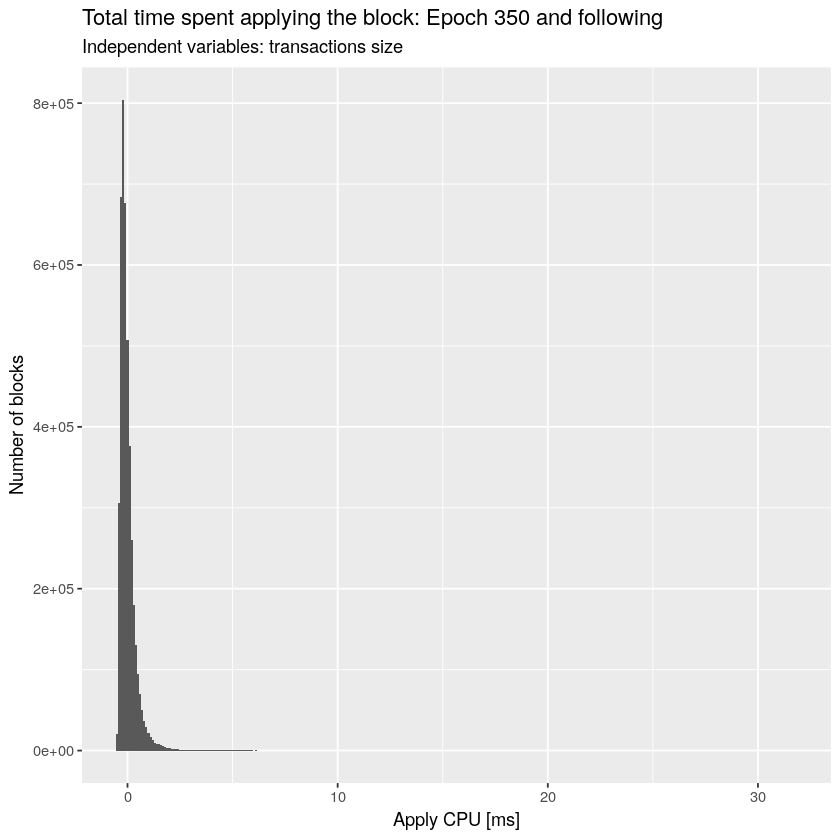

In [46]:
ggplot(data.table(`Actual - Fit [ms]`=residuals(model)), aes(`Actual - Fit [ms]`)) +
    geom_histogram(binwidth=0.1) +
    xlab("Apply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transactions size"
    )

#### Independent variables: transactions count and execution steps

In [47]:
model <- lm(
    `Apply CPU [ms]` ~ 0 + `Tx count` + `Tx exec [step]`, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit]
)
model %>% summary


Call:
lm(formula = `Apply CPU [ms]` ~ 0 + `Tx count` + `Tx exec [step]`, 
    data = timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit])

Residuals:
    Min      1Q  Median      3Q     Max 
-54.793  -0.366   0.428   1.682  31.886 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
`Tx count`       2.624e-01  1.318e-04    1991   <2e-16 ***
`Tx exec [step]` 9.487e-10  5.400e-13    1757   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.003 on 4342017 degrees of freedom
Multiple R-squared:  0.9077,	Adjusted R-squared:  0.9077 
F-statistic: 2.136e+07 on 2 and 4342017 DF,  p-value: < 2.2e-16


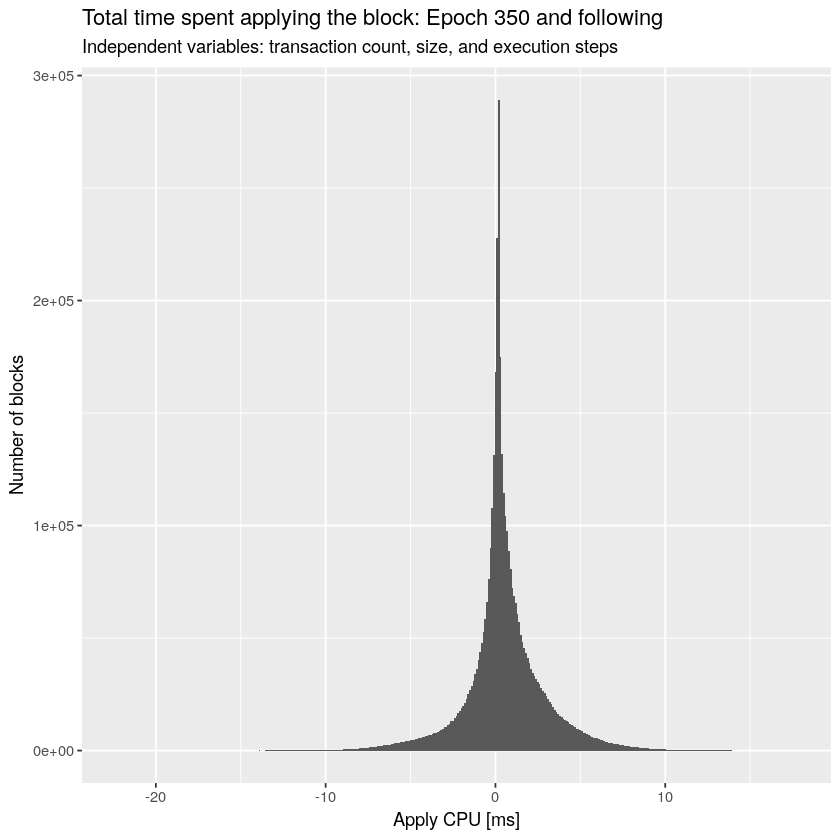

In [48]:
ggplot(timingsFit, aes(x=`Residual [ms]`)) +
    geom_histogram(binwidth=0.1) +
    xlab("Apply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

### Linear models for re-application

#### Independent variables: transactions size

In [49]:
model <- lm(
    `Reapply CPU [ms]` ~ `Tx size [kB]`, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit]
)
model %>% summary


Call:
lm(formula = `Reapply CPU [ms]` ~ `Tx size [kB]`, data = timings[`Tx count` > 
    0 & `Apply CPU [ms]` <= timeLimit])

Residuals:
    Min      1Q  Median      3Q     Max 
  -2.00   -0.31   -0.13    0.10 1505.28 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.539e-01  3.181e-03   111.2   <2e-16 ***
`Tx size [kB]` 2.151e-02  7.451e-05   288.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.449 on 4342017 degrees of freedom
Multiple R-squared:  0.01883,	Adjusted R-squared:  0.01883 
F-statistic: 8.335e+04 on 1 and 4342017 DF,  p-value: < 2.2e-16


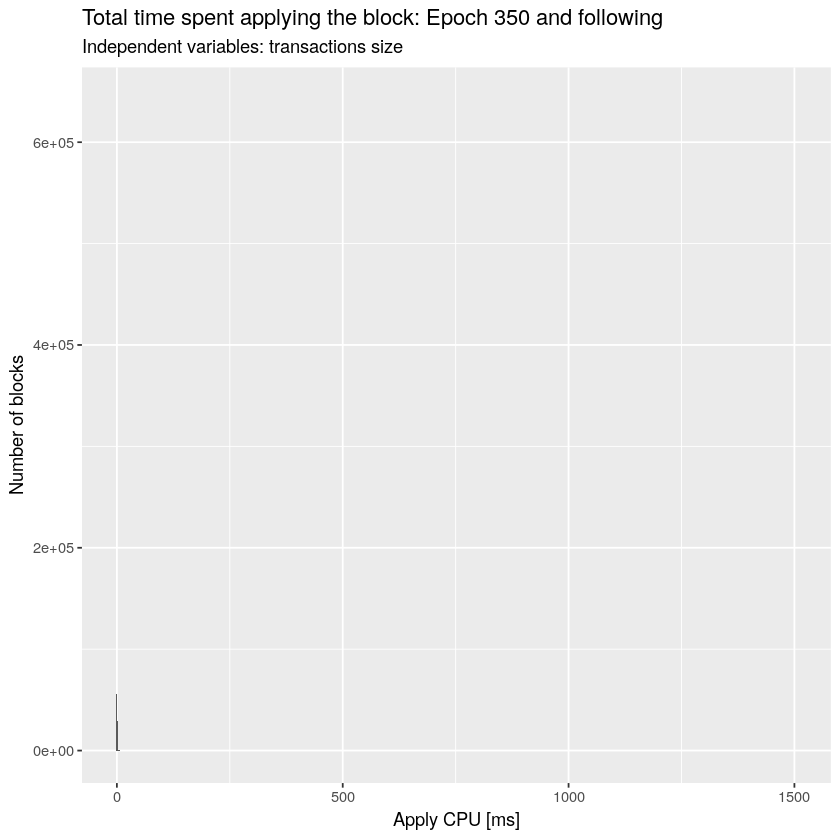

In [50]:
ggplot(data.table(`Actual - Fit [ms]`=residuals(model)), aes(`Actual - Fit [ms]`)) +
    geom_histogram(binwidth=0.1) +
    xlab("Apply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transactions size"
    )

#### Independent variables: transactions size and execution steps

In [51]:
model <- lm(
    `Reapply CPU [ms]` ~ `Tx size [kB]` + `Tx exec [step]`, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit]
)
model %>% summary


Call:
lm(formula = `Reapply CPU [ms]` ~ `Tx size [kB]` + `Tx exec [step]`, 
    data = timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit])

Residuals:
    Min      1Q  Median      3Q     Max 
  -2.03   -0.30   -0.12    0.10 1505.17 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.478e-01  3.195e-03  108.87   <2e-16 ***
`Tx size [kB]`   1.943e-02  1.256e-04  154.71   <2e-16 ***
`Tx exec [step]` 2.127e-11  1.033e-12   20.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.449 on 4342016 degrees of freedom
Multiple R-squared:  0.01893,	Adjusted R-squared:  0.01893 
F-statistic: 4.189e+04 on 2 and 4342016 DF,  p-value: < 2.2e-16


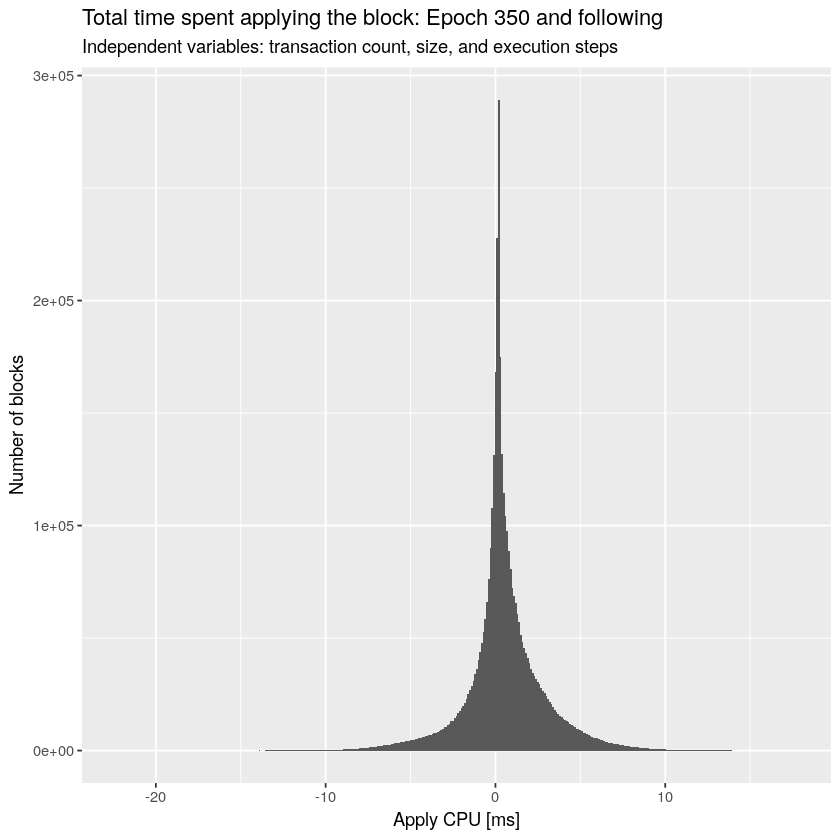

In [52]:
ggplot(timingsFit, aes(x=`Residual [ms]`)) +
    geom_histogram(binwidth=0.1) +
    xlab("Apply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

## Addendum 2

### Raw statistics

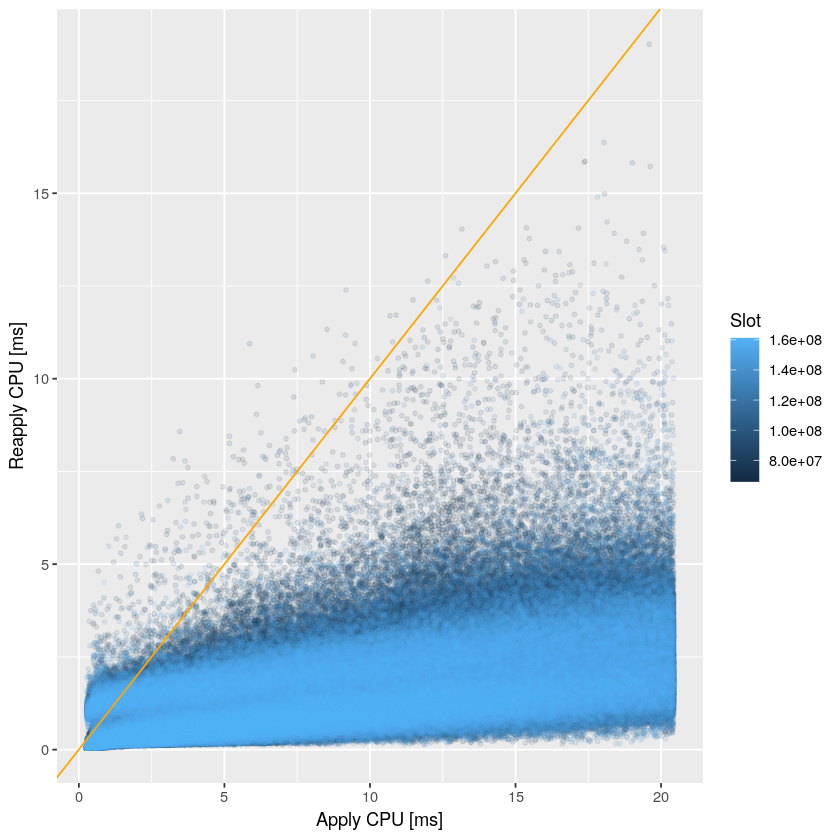

In [8]:
ggplot(
    timings[`Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= timeLimit], 
    aes(x=`Apply CPU [ms]`, y=`Reapply CPU [ms]`, color=`Slot`)
) +
    geom_point(size=1, alpha=0.1) +
    geom_abline(intercept=0, slope=1, color="orange")

In [9]:
ggsave("apply-vs-reapply.png", units="in", dpi=150, width=12, height=8)

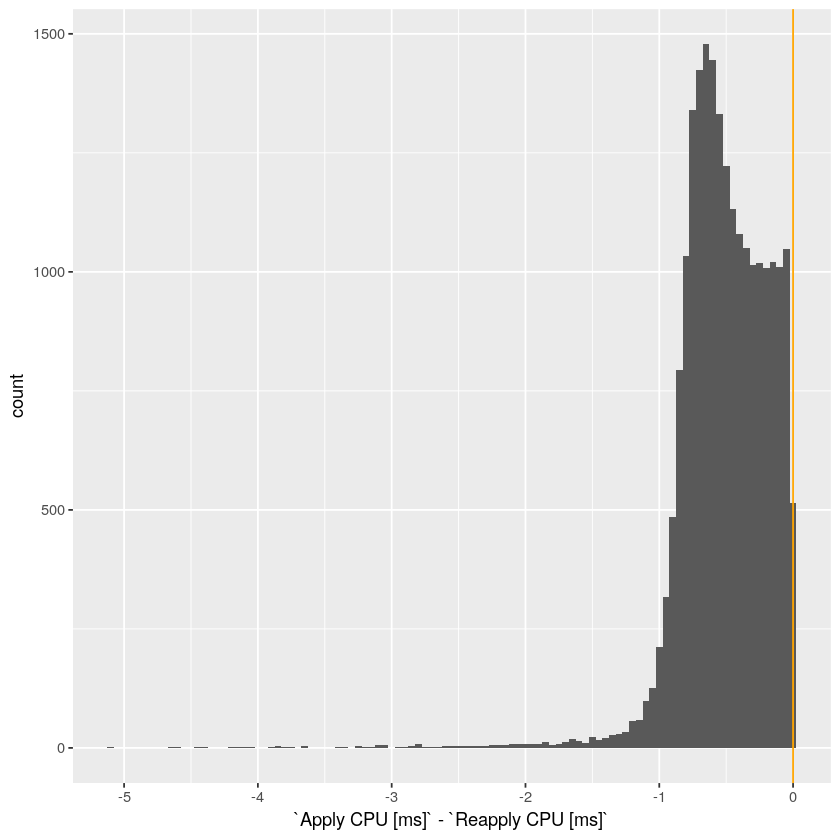

In [10]:
ggplot(
    timings[`Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= timeLimit & `Apply CPU [ms]` < `Reapply CPU [ms]`], 
    aes(x=`Apply CPU [ms]`-`Reapply CPU [ms]`)
) +
    geom_histogram(binwidth=0.05) +
    geom_vline(xintercept=0, color="orange")

In [11]:
ggsave("apply-minus-reapply.png", units="in", dpi=150, width=12, height=8)

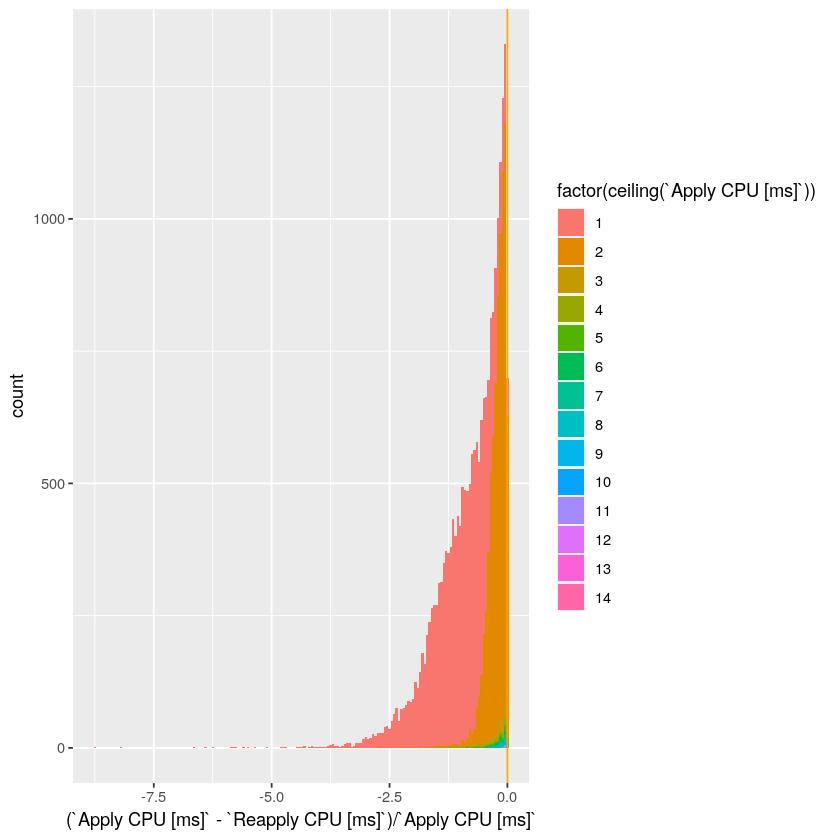

In [12]:
ggplot(
    timings[`Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= timeLimit & `Apply CPU [ms]` < `Reapply CPU [ms]`], 
    aes(x=(`Apply CPU [ms]` - `Reapply CPU [ms]`)/`Apply CPU [ms]`, fill=factor(ceiling(`Apply CPU [ms]`)))
) +
    geom_histogram(binwidth=0.05) +
    geom_vline(xintercept=0, color="orange")

In [13]:
ggsave("apply-over-reapply.png", units="in", dpi=150, width=16, height=8)

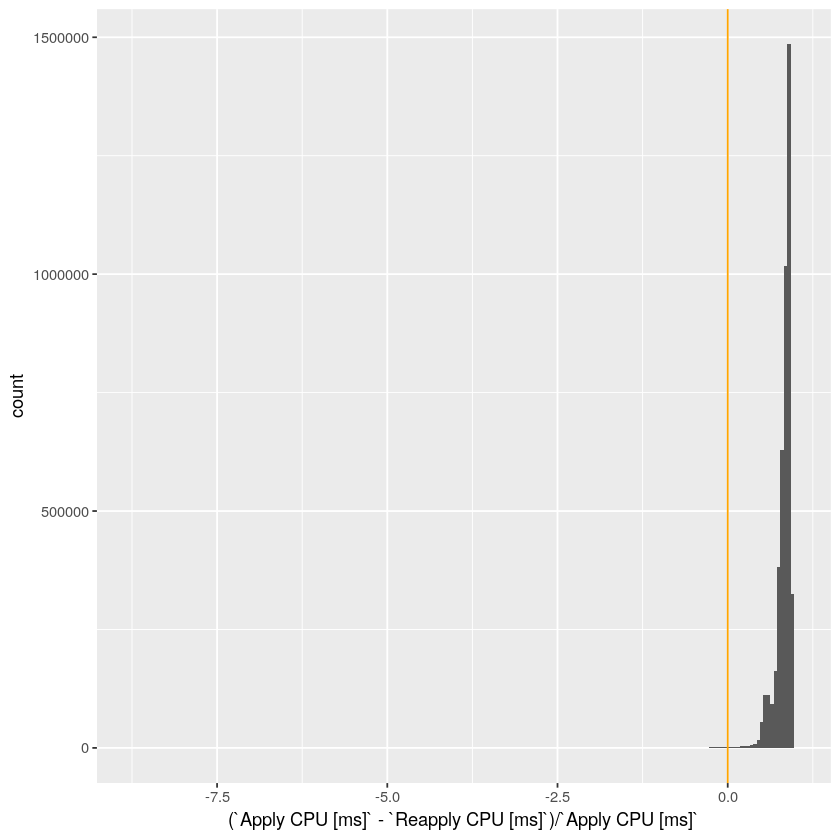

In [14]:
ggplot(
    timings[`Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= timeLimit], 
    aes(x=(`Apply CPU [ms]` - `Reapply CPU [ms]`)/`Apply CPU [ms]`)
) +
    geom_histogram(binwidth=0.05) +
    geom_vline(xintercept=0, color="orange")

In [15]:
ggsave("apply-over-reapply-unconditioned.png", units="in", dpi=150, width=16, height=8)

In [16]:
timings[, .(`Apply CPU [ms]`, `Reapply CPU [ms]`)] %>% summary

 Apply CPU [ms]      Reapply CPU [ms]   
 Min.   :    0.255   Min.   :    0.046  
 1st Qu.:    2.087   1st Qu.:    0.357  
 Median :    5.593   Median :    0.693  
 Mean   :    8.202   Mean   :    1.205  
 3rd Qu.:   11.468   3rd Qu.:    1.351  
 Max.   :21960.779   Max.   :21445.038  

In [17]:
timings[, sum(`Apply CPU [ms]`) / sum(`Reapply CPU [ms]`)]

[1] 6.808825

In [18]:
timings[`Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= timeLimit, sum(`Apply CPU [ms]`) / sum(`Reapply CPU [ms]`)]

[1] 7.331703

In [19]:
timings[, `Apply CPU [ms]` / `Reapply CPU [ms]`] %>% summary

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.001    4.796    7.217    7.783    9.943 7145.733 

In [20]:
timings[
    `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= timeLimit,
    .(`Number of blocks`=.N),
    .(`Apply > Reapply`=`Apply CPU [ms]`>`Reapply CPU [ms]`)
][
    ,
    .(`Apply > Reapply`, `Number of blocks`, `Fraction of blocks`=`Number of blocks`/sum(`Number of blocks`))
]

Apply > Reapply,Number of blocks,Fraction of blocks
<lgl>,<int>,<dbl>
TRUE,4415867,0.995103206
FALSE,21730,0.004896794


In [21]:
timings[
    `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= timeLimit & `Apply CPU [ms]` <`Reapply CPU [ms]`,
    summary(`Reapply CPU [ms]`/`Apply CPU [ms]`)
]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.228   1.604   1.769   2.157   9.771 

### Quantile regression for application

In [5]:
somePlutus <- timings[, `Tx exec [step]` > 0]
somePlutus <- sample(somePlutus %>% which, 500000)

In [6]:
cases <- data.table(`Tx count`=12000/1.5, `Tx size [kB]`=12000, `Tx exec [Gstep]`=c(0, 20,2000))
results <- cases

#### Independent variables: transactions count and execution steps

In [7]:
model <- rq(
    `Apply CPU [ms]` ~ 0 + `Tx count` + `Tx exec [Gstep]`, 
    timings[somePlutus, .(`Tx size [kB]`, `Tx count`, `Tx exec [Gstep]`=`Tx exec [step]`/1e9, `Apply CPU [ms]`)],
    tau=0.5
)
model %>% summary


Call: rq(formula = `Apply CPU [ms]` ~ 0 + `Tx count` + `Tx exec [Gstep]`, 
    tau = 0.5, data = timings[somePlutus, .(`Tx size [kB]`, `Tx count`, 
        `Tx exec [Gstep]` = `Tx exec [step]`/1e+09, `Apply CPU [ms]`)])

tau: [1] 0.5

Coefficients:
                  Value     Std. Error t value   Pr(>|t|) 
`Tx count`          0.24163   0.00046  527.74415   0.00000
`Tx exec [Gstep]`   1.12910   0.00213  529.74469   0.00000

In [8]:
results[, `50th %tile of Apply [ms]`:=predict.rq(model, cases) %>% as.numeric]

In [9]:
model <- rq(
    `Apply CPU [ms]` ~ 0 + `Tx count` + `Tx exec [Gstep]`, 
    timings[somePlutus, .(`Tx size [kB]`, `Tx count`, `Tx exec [Gstep]`=`Tx exec [step]`/1e9, `Apply CPU [ms]`)],
    tau=0.95
)
model %>% summary


Call: rq(formula = `Apply CPU [ms]` ~ 0 + `Tx count` + `Tx exec [Gstep]`, 
    tau = 0.95, data = timings[somePlutus, .(`Tx size [kB]`, 
        `Tx count`, `Tx exec [Gstep]` = `Tx exec [step]`/1e+09, 
        `Apply CPU [ms]`)])

tau: [1] 0.95

Coefficients:
                  Value     Std. Error t value   Pr(>|t|) 
`Tx count`          0.38053   0.00179  212.30382   0.00000
`Tx exec [Gstep]`   2.12161   0.00884  240.01777   0.00000

In [10]:
results[, `95th %tile of Apply [ms]`:=predict.rq(model, cases) %>% as.numeric]

In [11]:
model <- rq(
    `Apply CPU [ms]` ~ 0 + `Tx count` + `Tx exec [Gstep]`, 
    timings[somePlutus, .(`Tx size [kB]`, `Tx count`, `Tx exec [Gstep]`=`Tx exec [step]`/1e9, `Apply CPU [ms]`)],
    tau=0.99
)
model %>% summary


Call: rq(formula = `Apply CPU [ms]` ~ 0 + `Tx count` + `Tx exec [Gstep]`, 
    tau = 0.99, data = timings[somePlutus, .(`Tx size [kB]`, 
        `Tx count`, `Tx exec [Gstep]` = `Tx exec [step]`/1e+09, 
        `Apply CPU [ms]`)])

tau: [1] 0.99

Coefficients:
                  Value    Std. Error t value  Pr(>|t|)
`Tx count`         0.52192  0.00725   72.03351  0.00000
`Tx exec [Gstep]`  2.82637  0.03007   93.99523  0.00000

In [12]:
results[, `99th %tile of Apply [ms]`:=predict.rq(model, cases) %>% as.numeric]

### Quantile regression for re-application

#### Independent variables: transactions size and execution steps

In [13]:
model <- rq(
    `Reapply CPU [ms]` ~ `Tx size [kB]` + `Tx exec [Gstep]`, 
    timings[somePlutus, .(`Tx size [kB]`, `Tx exec [Gstep]`=`Tx exec [step]`/1e9, `Reapply CPU [ms]`)],
    tau=0.5
)
model %>% summary


Call: rq(formula = `Reapply CPU [ms]` ~ `Tx size [kB]` + `Tx exec [Gstep]`, 
    tau = 0.5, data = timings[somePlutus, .(`Tx size [kB]`, `Tx exec [Gstep]` = `Tx exec [step]`/1e+09, 
        `Reapply CPU [ms]`)])

tau: [1] 0.5

Coefficients:
                  Value     Std. Error t value   Pr(>|t|) 
(Intercept)         0.29459   0.00070  420.96193   0.00000
`Tx size [kB]`      0.01526   0.00006  271.02818   0.00000
`Tx exec [Gstep]`   0.03385   0.00050   67.11499   0.00000

In [14]:
results[, `50th %tile of Repply [ms]`:=predict.rq(model, cases) %>% as.numeric]

In [15]:
model <- rq(
    `Reapply CPU [ms]` ~ `Tx size [kB]` + `Tx exec [Gstep]`, 
    timings[somePlutus, .(`Tx size [kB]`, `Tx exec [Gstep]`=`Tx exec [step]`/1e9, `Reapply CPU [ms]`)],
    tau=0.95
)
model %>% summary


Call: rq(formula = `Reapply CPU [ms]` ~ `Tx size [kB]` + `Tx exec [Gstep]`, 
    tau = 0.95, data = timings[somePlutus, .(`Tx size [kB]`, 
        `Tx exec [Gstep]` = `Tx exec [step]`/1e+09, `Reapply CPU [ms]`)])

tau: [1] 0.95

Coefficients:
                  Value     Std. Error t value   Pr(>|t|) 
(Intercept)         1.07198   0.00563  190.38483   0.00000
`Tx size [kB]`      0.03099   0.00024  130.15923   0.00000
`Tx exec [Gstep]`   0.06890   0.00180   38.18726   0.00000

In [16]:
results[, `95th %tile of Reapply [ms]`:=predict.rq(model, cases) %>% as.numeric]

In [17]:
model <- rq(
    `Reapply CPU [ms]` ~ `Tx size [kB]` + `Tx exec [Gstep]`, 
    timings[somePlutus, .(`Tx size [kB]`, `Tx exec [Gstep]`=`Tx exec [step]`/1e9, `Reapply CPU [ms]`)],
    tau=0.99
)
model %>% summary

Warning message in summary.rq(.):
“3128 non-positive fis”



Call: rq(formula = `Reapply CPU [ms]` ~ `Tx size [kB]` + `Tx exec [Gstep]`, 
    tau = 0.99, data = timings[somePlutus, .(`Tx size [kB]`, 
        `Tx exec [Gstep]` = `Tx exec [step]`/1e+09, `Reapply CPU [ms]`)])

tau: [1] 0.99

Coefficients:
                  Value     Std. Error t value   Pr(>|t|) 
(Intercept)         1.39854   0.00523  267.18215   0.00000
`Tx size [kB]`      0.05537   0.00057   96.91999   0.00000
`Tx exec [Gstep]`   0.00477   0.00252    1.89164   0.05854

In [18]:
results[, `99th %tile of Reapply [ms]`:=predict.rq(model, cases) %>% as.numeric]

### Predictions

In [19]:
results

Tx count,Tx size [kB],Tx exec [Gstep],50th %tile of Apply [ms],95th %tile of Apply [ms],99th %tile of Apply [ms],50th %tile of Repply [ms],95th %tile of Reapply [ms],99th %tile of Reapply [ms]
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8000,12000,0,1933.041,3044.262,4175.337,183.3666,372.9985,665.7932
8000,12000,20,1955.623,3086.694,4231.864,184.0435,374.3766,665.8887
8000,12000,2000,4191.248,7287.479,9828.074,251.0571,510.8058,675.3397
